# CAPSTONE PROJECT

## Airbnb Analysis in Tokyo


In [1]:
# Packages needed for installing the libraries
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install mplleaflet
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install pygeoj
!{sys.executable} -m pip install pyshp
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install seaborn==0.10.0
!{sys.executable} -m pip install --upgrade cython
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install descartes


Requirement already up-to-date: cython in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (0.29.21)


## Importing the Libraries

In [138]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from numpy.random import seed
(seed(123))
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
# Geographical analysis
import geopandas as gpd #libspatialindex nees to be installed first
from shapely.geometry import Point
import json # library to handle JSON files
from pandas.io.json import json_normalize
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import requests
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
# accessibility analysis
import time
import shapefile as shp
import datetime
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import Counter
%matplotlib inline

print('Libraries Imported')

ModuleNotFoundError: No module named 'xgboost'

## Reading the data

In [3]:
raw_df = pd.read_csv('listings.csv.gz')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(2)

The dataset contains 11353 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20201229060739,2021-01-04,Oshiage Holiday Apartment,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,https://www.airbnb.com/users/show/964081,Yoshimi & Marek,2011-08-13,Tokyo,Would love to travel all over the world and me...,within a few hours,100%,88%,t,https://a0.muscache.com/im/users/964081/profil...,https://a0.muscache.com/im/users/964081/profil...,Sumida District,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,NaN,Sumida Ku,NaN,35.71721,139.82596,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Essentials"", ""Hangers"", ""Heating"", ""Fire ext...","$11,000.00",3,365,3,3,365,365,3.0,365.0,NaN,t,2,2,2,2,2021-01-04,165,2,0,2011-09-21,2020-03-04,95.0,10.0,10.0,10.0,10.0,9.0,10.0,M130003350,f,1,1,0,0,1.46
1,776070,https://www.airbnb.com/rooms/776070,20201229060739,2021-01-01,Kero-kero house room 1,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,https://www.airbnb.com/users/show/801494,Kei,2011-07-10,Japan,Love culture/foods/anime and to know about oth...,NaN,NaN,100%,t,https://a0.muscache.com/im/pictures/user/ba6d4...,https://a0.muscache.com/im/pictures/user/ba6d4...,Kita District,1.0,1.0,"['email', 'phone', 'manual_online', 'reviews',...",t,t,"Kita-ku, Tokyo, Japan",Kita Ku,NaN,35.73844,139.76917,Private room in house,Private room,2,NaN,1 shared bath,1.0,1.0,"[""Essentials"", ""Hot water"", ""Hangers"", ""Cable ...","$7,222.00",3,14,3,3,14,14,3.0,14.0,NaN,t,19,49,79,156,2021-01-01,228,2,0,2012-11-28,2020-01-18,99.0,10.0,10.0,10.0,10.0,10.0,10.0,M130000243,t,1,0,1,0,2.31


## Droping text columns

In [4]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'host_identity_verified', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_id', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)
df.head()

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,2011-08-13,within a few hours,100%,88%,t,1.0,1.0,t,NaN,Sumida Ku,NaN,35.71721,139.82596,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Essentials"", ""Hangers"", ""Heating"", ""Fire ext...","$11,000.00",3,365,3,3,365,365,3.0,365.0,NaN,t,2,2,2,2,165,2,0,2011-09-21,2020-03-04,95.0,10.0,10.0,10.0,10.0,9.0,10.0,M130003350,f,1,1,0,0,1.46
1,776070,2011-07-10,NaN,NaN,100%,t,1.0,1.0,t,"Kita-ku, Tokyo, Japan",Kita Ku,NaN,35.73844,139.76917,Private room in house,Private room,2,NaN,1 shared bath,1.0,1.0,"[""Essentials"", ""Hot water"", ""Hangers"", ""Cable ...","$7,222.00",3,14,3,3,14,14,3.0,14.0,NaN,t,19,49,79,156,228,2,0,2012-11-28,2020-01-18,99.0,10.0,10.0,10.0,10.0,10.0,10.0,M130000243,t,1,0,1,0,2.31
2,899003,2013-01-22,within an hour,100%,100%,f,2.0,2.0,t,NaN,Shinjuku Ku,NaN,35.70865,139.69681,Entire apartment,Entire home/apt,3,NaN,1 bath,1.0,4.0,"[""Pocket wifi"", ""Hot tub"", ""Hair dryer"", ""Hang...","$5,200.00",30,365,30,30,365,365,30.0,365.0,NaN,t,30,60,90,180,93,0,0,2013-02-13,2019-11-25,90.0,9.0,8.0,9.0,9.0,9.0,9.0,Other reasons | 【マンスリー契約】最低30泊以上の一時使用賃貸借契約を結びま...,f,2,2,0,0,0.97
3,1016831,2013-03-24,NaN,NaN,100%,f,1.0,1.0,t,"Setagaya, Tokyo, Japan",Setagaya Ku,NaN,35.65833,139.67153,Private room in house,Private room,2,NaN,1 shared bath,1.0,1.0,"[""Extra pillows and blankets"", ""Fire extinguis...","$11,000.00",1,60,1,1,1125,1125,1.0,1125.0,NaN,t,0,0,0,0,211,3,0,2013-04-06,2020-03-16,99.0,10.0,10.0,10.0,10.0,10.0,10.0,M130001107,t,1,0,1,0,2.24
4,1033276,2013-03-30,within a day,100%,80%,t,2.0,2.0,t,"足立区, 東京都, Japan",Adachi Ku,NaN,35.74253,139.79730,Private room in house,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Carbon monoxide alarm"", ""Heating"", ""Wifi"", ""...","$30,000.00",1,90,1,2,1125,1125,1.7,1125.0,NaN,t,30,60,90,270,72,0,0,2013-05-03,2018-06-17,91.0,10.0,9.0,10.0,10.0,9.0,9.0,M130007760,f,2,0,2,0,0.77


## Droping several Null entries

In [5]:
df.isna().sum()

id                                                  0
host_since                                         16
host_response_time                               1385
host_response_rate                               1385
host_acceptance_rate                              497
host_is_superhost                                  16
host_listings_count                                16
host_total_listings_count                          16
host_has_profile_pic                               16
neighbourhood                                    2429
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    11353
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                                       11353
bathrooms_text              

Let´s drop some columns

- "host_listings_count" and "host_total_listings_count" are the same
- neighbourhood_cleansed have better info than neighbourhood
- host_response_rate give us more information for analysis than host_response_time
- We will work just with minimum_nights and maximum_nights
- We will work just with the number_of_reviews
- First and last review

In [6]:
df.drop(['neighbourhood_group_cleansed', 'bathrooms', 'license', 'reviews_per_month', 'instant_bookable', 'calendar_updated', 'bathrooms', 'bathrooms_text', 'host_total_listings_count', 'neighbourhood', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm','number_of_reviews_ltm', 'number_of_reviews_l30d'], axis=1, inplace=True)
df.set_index('id', inplace=True)
df.head(3)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197677,2011-08-13,within a few hours,100%,88%,t,1.0,t,Sumida Ku,35.71721,139.82596,Entire apartment,Entire home/apt,4,1.0,2.0,"[""Essentials"", ""Hangers"", ""Heating"", ""Fire ext...","$11,000.00",3,365,t,2,2,2,2,165,2011-09-21,2020-03-04,95.0,10.0,10.0,10.0,10.0,9.0,10.0,1,1,0,0
776070,2011-07-10,NaN,NaN,100%,t,1.0,t,Kita Ku,35.73844,139.76917,Private room in house,Private room,2,1.0,1.0,"[""Essentials"", ""Hot water"", ""Hangers"", ""Cable ...","$7,222.00",3,14,t,19,49,79,156,228,2012-11-28,2020-01-18,99.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,1,0
899003,2013-01-22,within an hour,100%,100%,f,2.0,t,Shinjuku Ku,35.70865,139.69681,Entire apartment,Entire home/apt,3,1.0,4.0,"[""Pocket wifi"", ""Hot tub"", ""Hair dryer"", ""Hang...","$5,200.00",30,365,t,30,60,90,180,93,2013-02-13,2019-11-25,90.0,9.0,8.0,9.0,9.0,9.0,9.0,2,2,0,0


Let´s see what we have

In [7]:
lat_long = df[['latitude', 'longitude']]

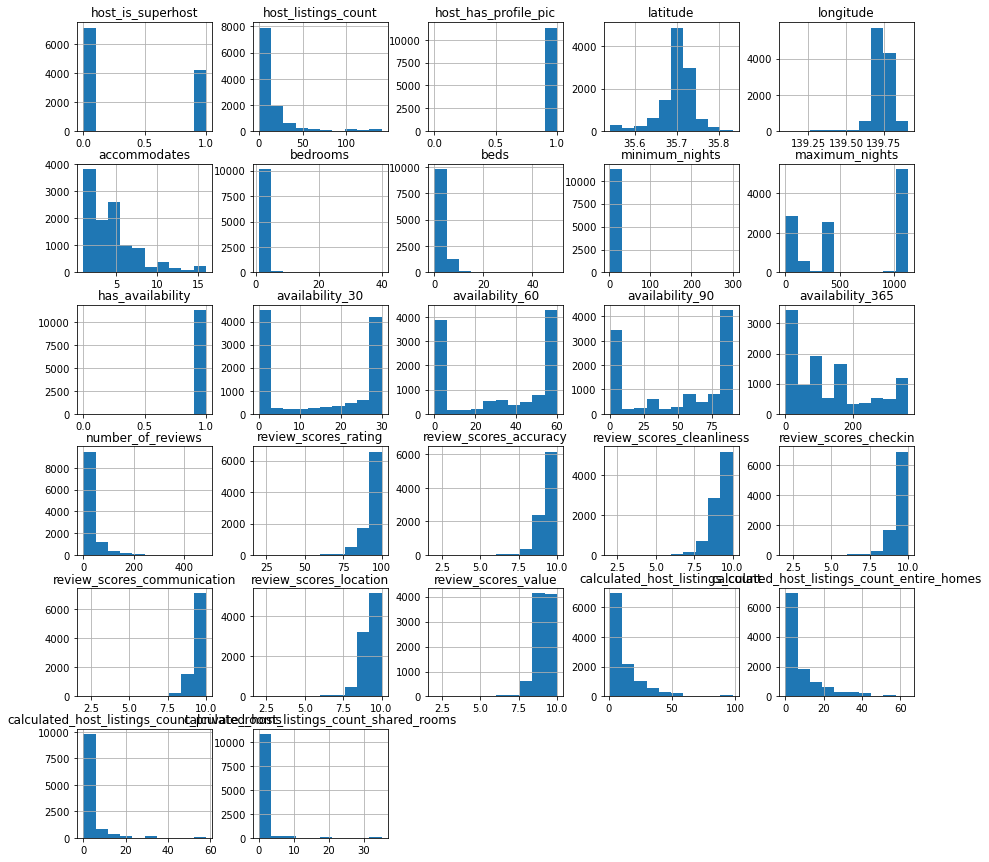

In [8]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)
# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(15,15));

Let´s drop the columns with just one category

In [9]:
df.drop(['has_availability', 'host_has_profile_pic', 'bedrooms', 'minimum_nights', 'latitude', 'longitude'], axis=1, inplace=True)

### Description of the columns

- host_response_rate: proportion of messages that the host replies to.
- host_acceptance_rate: proportion of customers that the host accept.
- host_is_superhost: whether or not the host is a superhost.
- host_listings_count: how many listings the host has in total.
- host_identity_verified: whether or not the host has been verified with id.
- neighbourhood_cleansed: the neighbourhood the property is in
- property_type: type of property, e.g. house or flat.         
- room_type: type of listing, e.g. entire home, private room or shared room.            
- accommodates: how many people the property accommodates.        
- bathrooms_text: type of bathroom.                                    
- beds: number of beds.            
- amenities: list of amenities.                                          
- price: nightly advertised price (the target variable).                                              
- maximum_nights: the maximum length of stay.                                     
- availability_30: how many nights are available to be booked in the next 30 days.                                    
- availability_60: how many nights are available to be booked in the next 60 days.                                    
- availability_90: how many nights are available to be booked in the next 90 days.                                    
- availability_365: how many nights are available to be booked in the next 365 days.                                   
- number_of_reviews: the number of reviews left for the property.                                  
- review_scores_rating: guests can score properties overall from 1 to 5 stars.                           
- review_scores_accuracy: guests can score the accuracy of a property's description from 1 to 5 stars.                          
- review_scores_cleanliness: guests can score a property's cleanliness from 1 to 5 stars.                      
- review_scores_checkin: guests can score their check-in from 1 to 5 stars.                          
- review_scores_communication: guests can score a host's communication from 1 to 5 stars.
- review_scores_location: guests can score a property's location from 1 to 5 stars.                         
- review_scores_value: guests can score a booking's value for money from 1 to 5 stars.                             
- license: type of license of the property                                           
- instant_bookable: whether or not the property can be instant booked (i.e. booked straight away, without having to message the host).
- calculated_host_listings_count: Count of total listing of the host                   
- calculated_host_listings_count_entire_homes: Count of total homes listings of the host
- calculated_host_listings_count_private_rooms: Count of total private rooms listings of the host      
- calculated_host_listings_count_shared_rooms: Count of total shared rooms listings of the host      
- reviews_per_month: calculated field of the average number of reviews left by guest each month                               

In [10]:
df.isna().sum()

host_since                                        16
host_response_time                              1385
host_response_rate                              1385
host_acceptance_rate                             497
host_is_superhost                                 16
host_listings_count                               16
neighbourhood_cleansed                             0
property_type                                      0
room_type                                          0
accommodates                                       0
beds                                              67
amenities                                          0
price                                              0
maximum_nights                                     0
availability_30                                    0
availability_60                                    0
availability_90                                    0
availability_365                                   0
number_of_reviews                             

## Cleaning individual columns

### host_since

This datetime column will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (December 29, 2020). The original column will be left in initially for EDA, and dropped later.

In [11]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (pd.datetime(2020, 9, 29) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1007.0
Median days as host: 818.0


### host_response_time

In [12]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
print("Number of rows without a value:", len(df[df.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2]))

Null values: 1385
Proportion: 12.2%
Number of rows without a value: 518


This section of the data set consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking). These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area.

In [13]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.719369
unknown               0.121994
within a few hours    0.076456
within a day          0.058575
a few days or more    0.023606
Name: host_response_time, dtype: float64

So, you have 71% of chances to receive an answer from the host within an hour.

### host_response_rate

In [14]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 1385
Proportion: 12.2%


In [15]:
# Removing the % sign from the "host_response_rate" string and converting it to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')
print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 95.0
Median host response rate: 100.0
Proportion of 100% host response rates: 82.7%


In [16]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       8248
unknown    1385
50-89%      883
90-99%      478
0-49%       359
Name: host_response_rate, dtype: int64

### host_acceptance_rate 

In [17]:
print("Null values:", df.host_acceptance_rate.isna().sum())
print(f"Proportion: {round((df.host_acceptance_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 497
Proportion: 4.4%


In [18]:
# Removing the % sign from the "host_response_rate" string and converting it to an integer
df.host_acceptance_rate = df.host_acceptance_rate.str[:-1].astype('float64')
print("Mean host acceptance rate:", round(df['host_acceptance_rate'].mean(),0))
print("Median host acceptance rate:", df['host_acceptance_rate'].median())

Mean host acceptance rate: 97.0
Median host acceptance rate: 100.0


### host_is_superhost

In [19]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since', 'host_is_superhost', 'host_listings_count'] ].isnull().sum(axis=1) == 5])

0

In [20]:
df.host_is_superhost.fillna("unknown", inplace=True)
df.host_is_superhost.value_counts(normalize=False)

0.0        7133
1.0        4204
unknown      16
Name: host_is_superhost, dtype: int64

### host_listings_count

In [21]:
print("Null values:", df.host_listings_count.isna().sum())
print(f"Proportion: {round((df.host_listings_count.isna().sum()/len(df))*100, 1)}%")

Null values: 16
Proportion: 0.1%


### neighbourhood_cleansed

In [22]:
df.neighbourhood_cleansed.fillna("unknown", inplace=True)
df.neighbourhood_cleansed.value_counts(normalize=False)

Shinjuku Ku            2163
Taito Ku               1671
Toshima Ku             1084
Sumida Ku              1065
Shibuya Ku              671
Minato Ku               471
Chuo Ku                 403
Ota Ku                  402
Katsushika Ku           313
Nakano Ku               309
Kita Ku                 302
Arakawa Ku              285
Setagaya Ku             277
Suginami Ku             232
Itabashi Ku             217
Shinagawa Ku            216
Edogawa Ku              193
Koto Ku                 191
Chiyoda Ku              176
Adachi Ku               172
Bunkyo Ku               135
Meguro Ku                86
Nerima Ku                70
Hachioji Shi             32
Machida Shi              26
Hino Shi                 23
Nishitokyo Shi           19
Mitaka Shi               13
Chofu Shi                12
Higashimurayama Shi      12
Musashino Shi            11
Tama Shi                 11
Akiruno Shi              10
Kokubunji Shi            10
Kodaira Shi              10
Kunitachi Shi       

### property_type

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories "Apartment", "House" and "Other" will be used, as most properties can be classified as either apartment or house.

In [23]:
df.property_type.fillna("unknown", inplace=True)
df.property_type.value_counts(normalize=False)

Entire apartment                      6015
Entire house                          1220
Private room in house                  637
Private room in apartment              605
Room in hotel                          565
Entire condominium                     266
Room in aparthotel                     248
Room in boutique hotel                 238
Room in hostel                         232
Shared room in hostel                  229
Private room in hostel                 221
Entire serviced apartment              129
Shared room in house                   112
Entire villa                            84
Private room in ryokan                  63
Private room in condominium             47
Entire loft                             43
Shared room in apartment                36
Room in serviced apartment              32
Private room in villa                   27
Private room in guesthouse              24
Private room in bed and breakfast       23
Private room in serviced apartment      22
Shared room

In [24]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Private room in house': 'Private room',
    'Entire apartment': 'Apartment',
    'Entire house': 'House',
    'Private room in apartment': 'Private room',
    'Room in hotel': 'Private room',
    'Entire condominium': 'Apartment',
    'Room in aparthotel': 'Private room',
    'Room in boutique hotel': 'Private room',
    'Room in hostel': 'Private room',
    'Shared room in hostel': 'Shared room',
    'Private room in hostel': 'Private room',
    'Entire serviced apartment': 'Apartment',
    'Shared room in house': 'Shared room',
    'Entire villa': 'House',
    'Private room in ryokan': 'Private room',
    'Private room in condominium': 'Private room',
    'Entire loft': 'House',
    'Shared room in apartment': 'Shared room',
    'Room in serviced apartment': 'Private room',
    'Private room in villa': 'Private room',
    'Private room in guesthouse': 'Private room',
    'Private room in bed and breakfast': 'Private room',
    'Private room in serviced apartment': 'Private room',
    'Shared room in ryokan': 'Shared room',
    'Entire townhouse': 'House',
    'Room in ryokan': 'Private room',
    'Hut': 'House',
    'Shared room in hotel': 'Shared room',
    'Private room in hut': 'Private room',
    'Shared room in hut': 'Shared room',
    'Room in bed and breakfast': 'Private room',
    'Entire guest suite': 'Private room',
    'Entire guesthouse': 'House',
    'Shared room in bed and breakfast': 'Shared room',
    'Private room in guest suite': 'Private room',
    'Private room in tiny house': 'Private room',
    'Private room in townhouse': 'Private room',
    'Private room in cabin': 'Private room',
    'Private room in nature lodge': 'Private room',
    'Private room in resort': 'Private room',
    'Room in apartment': 'Private room',
    'Private room in dome house': 'Private room',
    'Shared room in tiny house': 'Shared room',
    'Shared room in aparthotel': 'Shared room',
    'Shared room in cabin': 'Shared room',
    'Shared room in guesthouse': 'Shared room',
    'Shared room in dorm': 'Shared room',
    'Shared room in loft': 'Shared room',
    'Shared room in condominium': 'Shared room',
    'Entire cabin': 'Private room',
    'Private room in tent': 'Private room',
    'Private room in castle': 'Private room',
    'Private room in camper/rv': 'Private room',
    'Earth house': 'House',
     }, inplace=True)
# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment','Shared room', 'Private room' ]), 'property_type'] = 'Other'

In [25]:
df.property_type.value_counts(normalize=False)

Apartment       6410
Private room    3073
House           1395
Shared room      454
Other             21
Name: property_type, dtype: int64

### amenities

"Amenities" is a list of additional features in the property, i.e. whether it has a TV or parking.

In [26]:
# Creating a set of possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)

In the list above, some amenities are more important than others, and some are likely to be fairly uncommon.

In [27]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector|screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [28]:
# Replacing nulls with zeros for new columns
replace_nulls = df.iloc[:,41:].columns
df[replace_nulls] = df[replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['gym', 'child_friendly', 'outdoor_space', 'host_greeting', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


In [29]:
df.columns[40:]

Index(['tv', 'coffee_machine', 'cooking_basics', 'white_goods', 'elevator',
       'parking', 'hot_tub_sauna_or_pool', 'internet', 'long_term_stays',
       'private_entrance'],
      dtype='object')

### Price

"price" is a string because there is a currency sign. It will be converted to an integer.

In [30]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

### First review and last review

- We Calculate the number of days between the first review and the date the data was scraped
- Distribution of the number of days since first review
- Same analysis for the last review

In [31]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")


Null values in 'first_review': 20.3%
Null values in 'review_scores_rating': 20.3%


In [32]:
# Convert to datetime
df.first_review = pd.to_datetime(df.first_review)

# Calculate the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (pd.datetime(2020, 9, 29) - df.first_review).astype('timedelta64[D]')

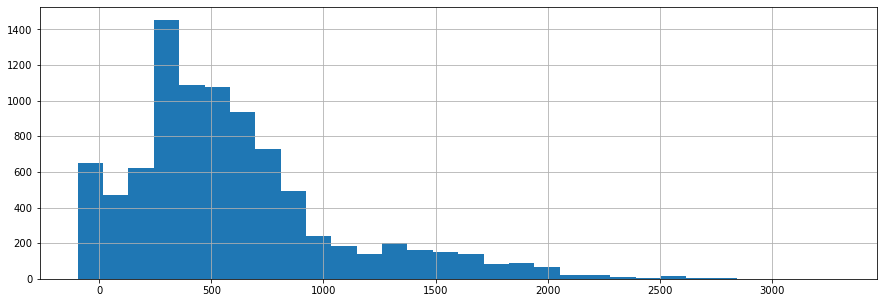

In [33]:
# Distributing the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [34]:
def bin_column(col, bins, labels, na_label='unknown'):
    """ Takes in a column name, bin cut points and labels, replaces the original column 
    with a binned version, and replaces nulls (with 'unknown' if unspecified). """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [35]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

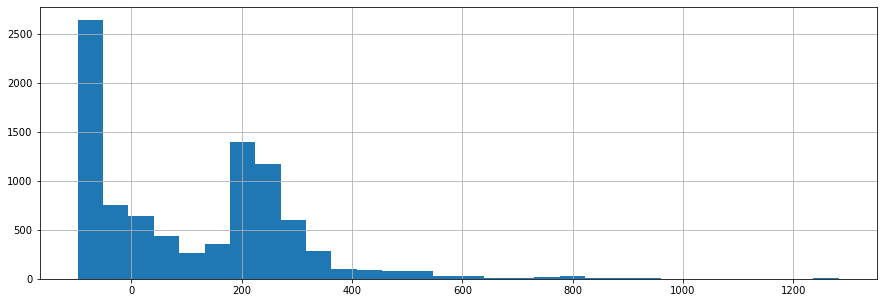

In [36]:
# Same process for "last_review"
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (pd.datetime(2020, 9, 29) - df.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [37]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

Dropping "last_review" - "first_review" will be kept for EDA and dropped later

In [38]:
df.drop('last_review', axis=1, inplace=True)

### review ratings columns

Listings without reviews will be kept and replaced with unknown. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together, as this is a 'low' rating, by Airbnb standards.

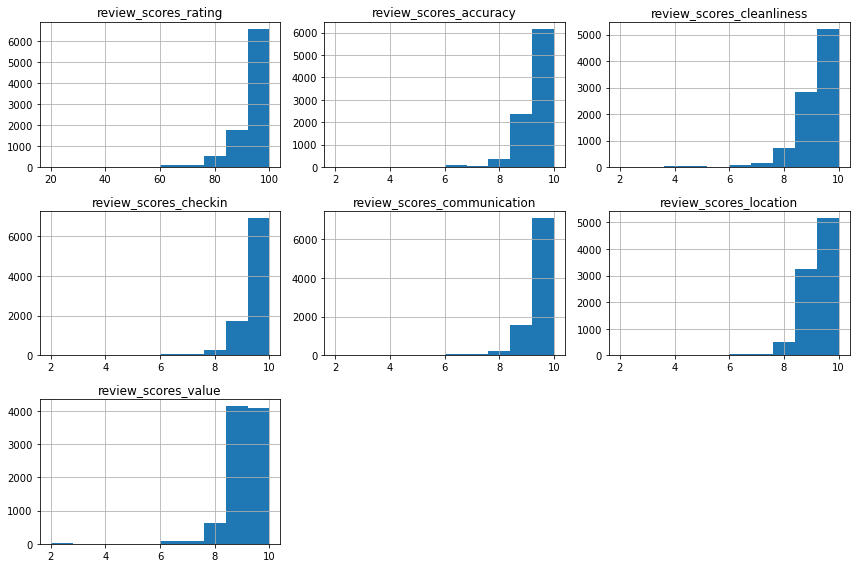

In [39]:
# Checking the distributions of the review ratings columns
plotted_variables = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(plotted_variables):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [40]:
# Create a list of all columns that are scored out of 10
plotted_variables.pop(0)

'review_scores_rating'

In [41]:
# Binning for all columns that scored out of 10
for col in plotted_variables:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [42]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

### number_of_reviews_ltm and reviews_per_month

These columns will be highly correlated with "number_of_reviews", so they will be dropped.

In [43]:
df.dtypes

host_since                                      datetime64[ns]
host_response_time                                      object
host_response_rate                                      object
host_acceptance_rate                                   float64
host_is_superhost                                       object
host_listings_count                                    float64
neighbourhood_cleansed                                  object
property_type                                           object
room_type                                               object
accommodates                                             int64
beds                                                   float64
price                                                    int64
maximum_nights                                           int64
availability_30                                          int64
availability_60                                          int64
availability_90                                        

Let´s drop the last columns

In [44]:
listings_cleaned = df.to_csv(r'listings_cleaned.csv', index=id, header=True)

# Exloratory Data Analysis

### Time Series

In [45]:
# Read the cleansed dataset
df = pd.read_csv('listings_cleaned.csv', index_col=0)

In [46]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [47]:
print(f"Of all the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of all the Airbnb hosts that are still listing on the site, the first joined on 03 July 2011, and the most recent joined on 22 December 2020.


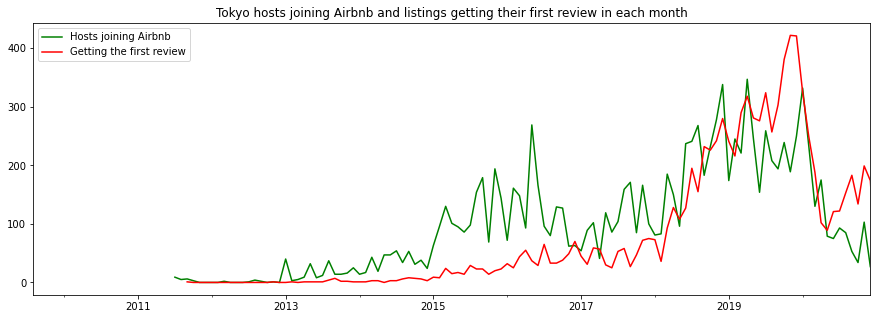

In [48]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='green')
df.set_index('first_review').resample('MS').size().plot(label='Getting the first review', color='red')
plt.title('Tokyo hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-08-20', '2020-12-29') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [49]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [50]:

def decompose_time_series(df, title=''):
    """Plots the original time series and its decomposition into trend, seasonal and residual."""
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

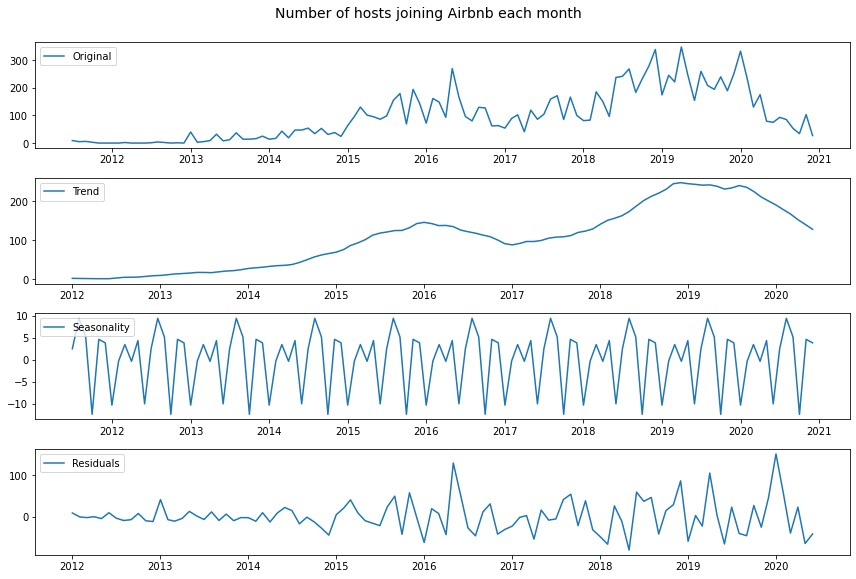

In [51]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

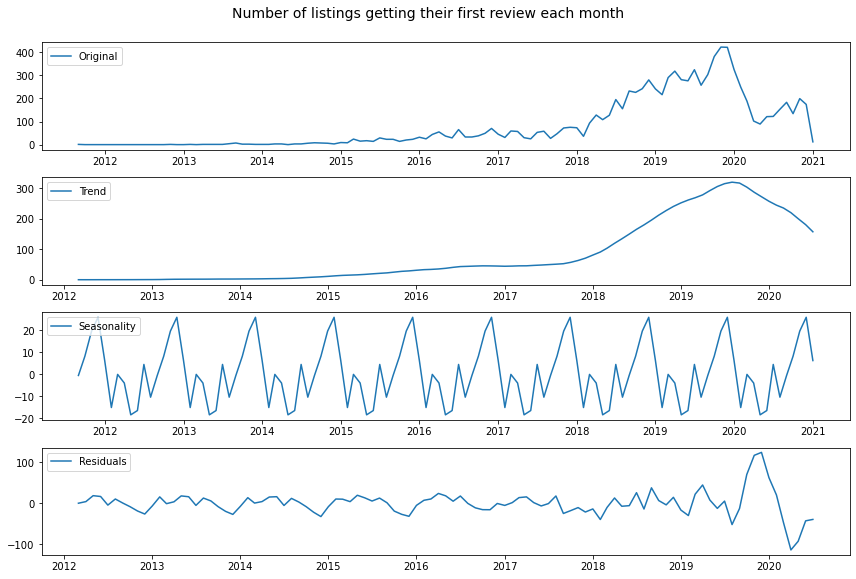

In [52]:
decompose_time_series(ts_first_review, title='Number of listings getting their first review each month')

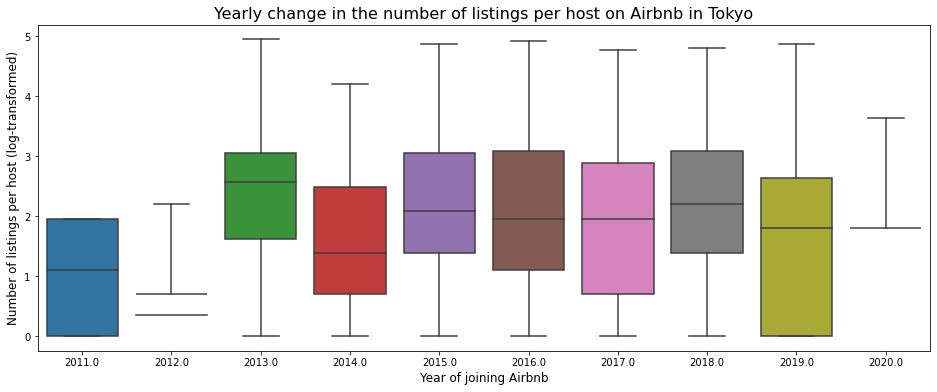

In [53]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year of joining Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Yearly change in the number of listings per host on Airbnb in Tokyo', fontsize=16)
plt.show()

In [54]:
print("Average number of listings per year in Tokyo:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per year in Tokyo:
host_since
2011-01-01     3.87
2012-01-01     1.90
2013-01-01    15.14
2014-01-01     9.37
2015-01-01    16.64
2016-01-01    19.56
2017-01-01    14.58
2018-01-01    16.55
2019-01-01    15.42
2020-01-01     5.24
Name: host_listings_count, dtype: float64


In [55]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
23814483,2018-03-09,94.0
36322195,2015-04-22,96.0
34373062,2019-04-28,98.0
43119921,2018-11-27,110.0
33231604,2017-08-04,117.0
45833046,2018-12-14,121.0
41385907,2019-05-15,129.0
16976617,2016-06-04,136.0
31431029,2013-03-27,140.0


Now, let´s have a look to the prices

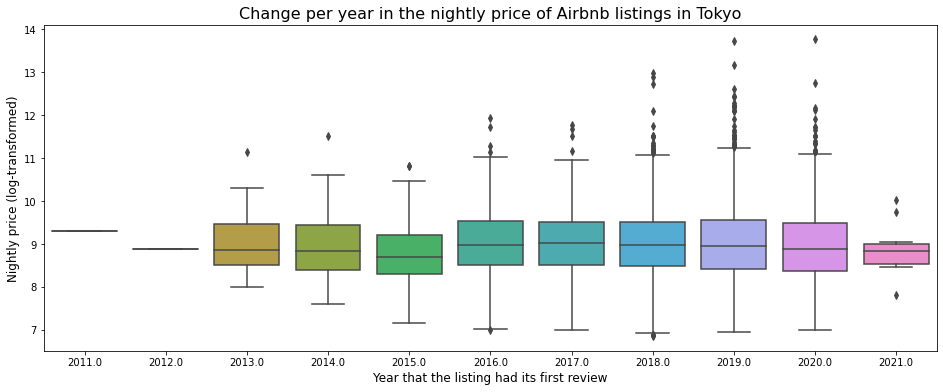

In [56]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Tokyo', fontsize=16)
plt.show()

In [57]:
print("Mean nightly price of listings in each year in Tokyo:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year in Tokyo:
first_review
2011-01-01    11000.00
2012-01-01     7222.00
2013-01-01    13680.62
2014-01-01    12023.18
2015-01-01     8481.13
2016-01-01    11791.37
2017-01-01    11498.11
2018-01-01    12391.06
2019-01-01    13326.46
2020-01-01    11934.01
2021-01-01     8457.17
Name: price, dtype: float64


In [58]:
print("Median nightly price of listings in each year in Tokyo:")
print(round(df.set_index('first_review').price.resample('YS').median(),2))

Median nightly price of listings in each year in Tokyo:
first_review
2011-01-01    11000
2012-01-01     7222
2013-01-01     6980
2014-01-01     6890
2015-01-01     6000
2016-01-01     8000
2017-01-01     8321
2018-01-01     8000
2019-01-01     7677
2020-01-01     7200
2021-01-01     6900
Name: price, dtype: int64


In [59]:
# Drop "host_since" and "first_review" since they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

Numerical features

In [60]:
df.describe()

,host_acceptance_rate,host_listings_count,accommodates,beds,price,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_days_active,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,parking,hot_tub_sauna_or_pool,internet,long_term_stays,private_entrance
count,10856.000000,11337.000000,11353.00000,11286.000000,1.135300e+04,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,0.0,11239.0,202.0,70.0,2547.0,62.0,5754.0,305.0,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000,11353.000000
mean,96.609801,14.706360,4.36149,2.582492,1.396696e+04,629.365983,14.811239,32.238527,49.975777,127.798467,25.619572,12.811327,8.577909,2.469744,0.597463,1006.356293,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.738836,0.100414,0.438915,0.864970,0.316480,0.296486,0.107637,0.975249,0.510174,0.555360
std,9.586183,23.233021,3.09106,2.312124,3.490950e+04,475.315452,13.169300,25.647874,37.674558,117.621476,41.099224,14.874024,11.644250,6.470837,3.192337,670.822848,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.439289,0.300564,0.496276,0.341771,0.465123,0.456728,0.309935,0.155373,0.499919,0.496948
min,0.000000,0.000000,1.00000,0.000000,9.500000e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-84.000000,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98.000000,2.000000,2.00000,1.000000,4.571000e+03,120.000000,0.000000,0.000000,1.000000,11.000000,1.000000,3.000000,1.000000,0.000000,0.000000,468.000000,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,100.000000,7.000000,3.00000,2.000000,8.000000e+03,365.000000,17.000000,39.000000,61.000000,90.000000,9.000000,8.000000,4.000000,0.000000,0.000000,818.000000,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,100.000000,18.000000,6.00000,3.000000,1.400000e+04,1125.000000,29.000000,59.000000,88.000000,188.000000,32.000000,17.000000,12.000000,2.000000,0.000000,1579.000000,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,100.000000,140.000000,16.00000,50.000000,1.014286e+06,1125.000000,30.000000,60.000000,90.000000,365.000000,488.000000,98.000000,64.000000,58.000000,35.000000,3376.000000,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
print(f"Advertised prices range from {min(df.price)}yen to {max(df.price)}yen.")

Advertised prices range from 950yen to 1014286yen.


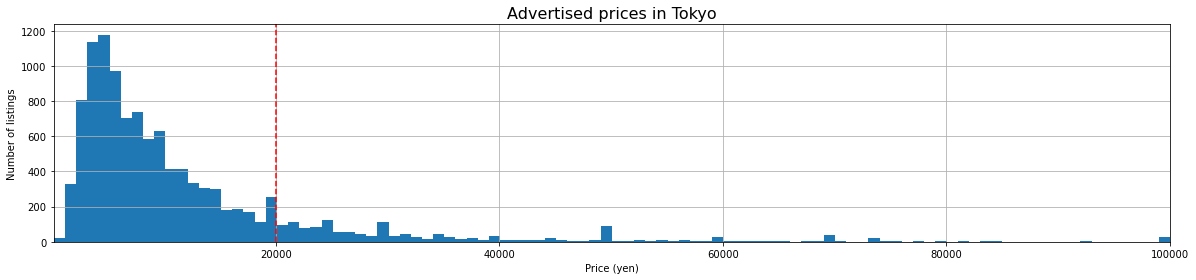

In [62]:
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(100,100000))
plt.margins(x=0)
plt.axvline(20000, color='red', linestyle='--')
plt.title("Advertised prices in Tokyo", fontsize=16)
plt.xlabel("Price (yen)")
plt.ylabel("Number of listings")
plt.show()

### Number of guests

In [63]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 7
Mean number of listings per host: 15
10% of listings are from hosts with one listing.


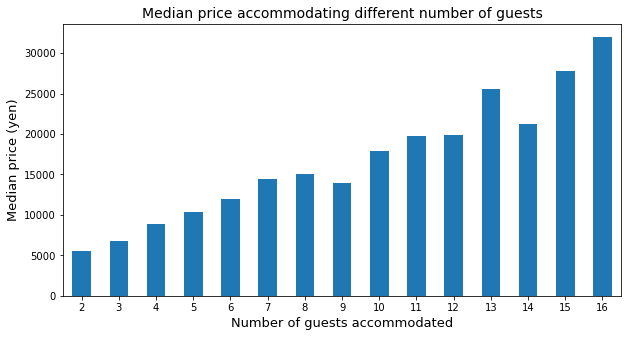

In [64]:

plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (yen)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

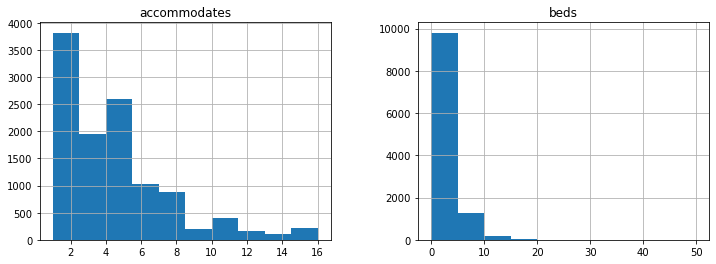

In [65]:
df[['accommodates', 'beds']].hist(figsize=(12,4));

## Categorical Features



Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

### Neighbourhood

In [66]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the Munich borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Edogawa Ku,None,"MULTIPOLYGON (((139.85780 35.63580, 139.85530 ..."
1,Mizuho Machi,None,"MULTIPOLYGON (((139.32091 35.77720, 139.32359 ..."
2,Katsushika Ku,None,"MULTIPOLYGON (((139.84680 35.79653, 139.85640 ..."
3,Shinagawa Ku,None,"MULTIPOLYGON (((139.77280 35.59560, 139.76680 ..."
4,Koto Ku,None,"MULTIPOLYGON (((139.82120 35.63413, 139.82040 ..."


In [67]:
# Drop the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Create a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

borough_map_df.head()

,geometry,number_of_listings,median_price
neighbourhood,,,
Edogawa Ku,"MULTIPOLYGON (((139.85780 35.63580, 139.85530 ...",193.0,8286.0
Mizuho Machi,"MULTIPOLYGON (((139.32091 35.77720, 139.32359 ...",NaN,NaN
Katsushika Ku,"MULTIPOLYGON (((139.84680 35.79653, 139.85640 ...",313.0,6640.0
Shinagawa Ku,"MULTIPOLYGON (((139.77280 35.59560, 139.76680 ...",216.0,8196.0
Koto Ku,"MULTIPOLYGON (((139.82120 35.63413, 139.82040 ...",191.0,6123.0


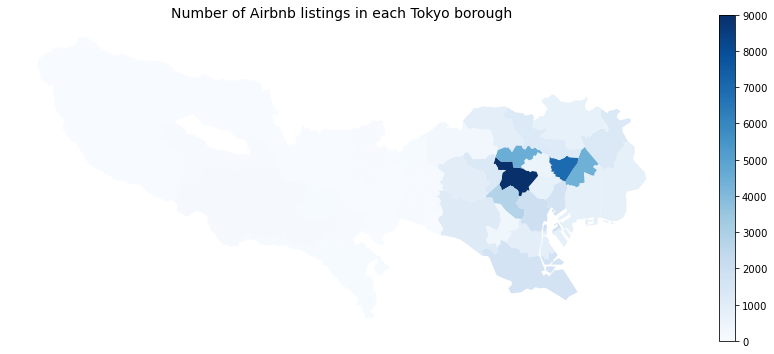

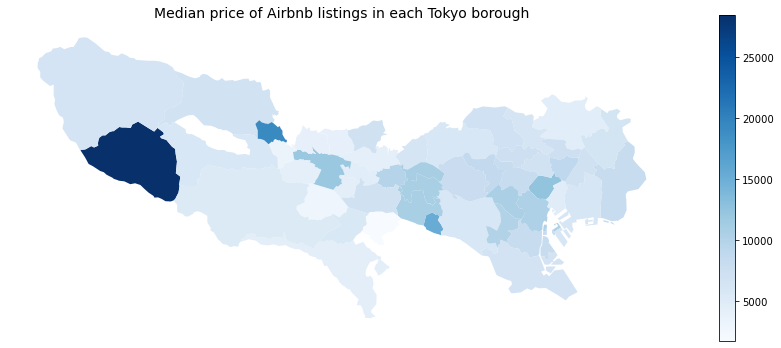

In [68]:
# Plot the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Tokyo borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plot the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Tokyo borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

### Venue proximity

We are looking to explore proximity to certain venues as a possible price predictor. Walkability and ability to reach places may be a deal-maker or breaker when it comes to choosing a accomodation.

In [69]:
CLIENT_ID = '4QLQRJVRSGSEBTB24O1EJAZW40G5OBPXOM5H5L53IBNGHC4B' # your Foursquare ID
CLIENT_SECRET = 'UWP0VWT2MFCDNI3321EXQC0AVEPAIRGGUCI1F2JN0OF5QZDP' # your Foursquare Secret
VERSION = '20200202'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4QLQRJVRSGSEBTB24O1EJAZW40G5OBPXOM5H5L53IBNGHC4B
CLIENT_SECRET:UWP0VWT2MFCDNI3321EXQC0AVEPAIRGGUCI1F2JN0OF5QZDP


Get the neighbourhood's names and shape

In [70]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y

In [71]:
map_df.loc[:, ~map_df.columns.str.contains('^Unnamed')]
print(map_df.shape)
map_df

(62, 4)


,neighbourhood,geometry,longitude,latitude
0,Edogawa Ku,"MULTIPOLYGON (((139.85780 35.63580, 139.85530 ...",139.875151,35.691777
1,Mizuho Machi,"MULTIPOLYGON (((139.32091 35.77720, 139.32359 ...",139.349213,35.774330
2,Katsushika Ku,"MULTIPOLYGON (((139.84680 35.79653, 139.85640 ...",139.855948,35.753259
3,Shinagawa Ku,"MULTIPOLYGON (((139.77280 35.59560, 139.76680 ...",139.732829,35.609800
4,Koto Ku,"MULTIPOLYGON (((139.82120 35.63413, 139.82040 ...",139.814738,35.661513
5,Hinode Machi,"MULTIPOLYGON (((139.16310 35.77820, 139.16750 ...",139.226364,35.758617
6,Higashiyamato Shi,"MULTIPOLYGON (((139.44080 35.76693, 139.44130 ...",139.426583,35.750472
7,Chiyoda Ku,"MULTIPOLYGON (((139.77010 35.70526, 139.77310 ...",139.754622,35.687723
8,Minato Ku,"MULTIPOLYGON (((139.76871 35.62647, 139.77670 ...",139.739364,35.651925
9,Komae Shi,"MULTIPOLYGON (((139.56200 35.63253, 139.56599 ...",139.577546,35.634841


In [72]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
      
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #results = requests.get(url).json()
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can run the above function on each neighborhood and create a new dataframe called tokyo_venues.

In [73]:
tokyo_venues = getNearbyVenues(names=map_df.neighbourhood,
                                latitudes=map_df.latitude,
                                longitudes=map_df.longitude,
                                radius = 1000
                                )
tokyo_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Edogawa Ku,35.691777,139.875151,Tonkatsu Den (とんかつ 田),35.685376,139.876378,Tonkatsu Restaurant
1,Edogawa Ku,35.691777,139.875151,Syabu-Yo (しゃぶ葉),35.694342,139.867494,Shabu-Shabu Restaurant
2,Edogawa Ku,35.691777,139.875151,Kura Sushi (くら寿司),35.685707,139.878834,Sushi Restaurant
3,Edogawa Ku,35.691777,139.875151,Saizeriya (サイゼリヤ),35.686123,139.882041,Italian Restaurant
4,Edogawa Ku,35.691777,139.875151,7-Eleven (セブンイレブン 江戸川西一之江3丁目店),35.695793,139.875711,Convenience Store
...,...,...,...,...,...,...,...
3852,Hamura Shi,35.763810,139.315464,Big-A (ビッグ・エー 羽村神明台店),35.756706,139.319210,Discount Store
3853,Hamura Shi,35.763810,139.315464,Hamura City Sports Center (羽村市スポーツセンター),35.768264,139.307612,Athletics & Sports
3854,Hamura Shi,35.763810,139.315464,Tonden (とんでん),35.756757,139.319709,Japanese Restaurant
3855,Hamura Shi,35.763810,139.315464,Karimoku Furniture (カリモク家具 多摩ショールーム),35.771729,139.313483,Furniture / Home Store


In [74]:
# Save the Dataset
tokyo_venues.to_csv('Tokyo_Venues.csv')

In [75]:
# Read dataset
tokyo_venues = pd.read_csv('Tokyo_Venues.csv', index_col=0)
print(tokyo_venues.shape)
tokyo_venues.head()

(3857, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Edogawa Ku,35.691777,139.875151,Tonkatsu Den (とんかつ 田),35.685376,139.876378,Tonkatsu Restaurant
1,Edogawa Ku,35.691777,139.875151,Syabu-Yo (しゃぶ葉),35.694342,139.867494,Shabu-Shabu Restaurant
2,Edogawa Ku,35.691777,139.875151,Kura Sushi (くら寿司),35.685707,139.878834,Sushi Restaurant
3,Edogawa Ku,35.691777,139.875151,Saizeriya (サイゼリヤ),35.686123,139.882041,Italian Restaurant
4,Edogawa Ku,35.691777,139.875151,7-Eleven (セブンイレブン 江戸川西一之江3丁目店),35.695793,139.875711,Convenience Store


In [76]:
print('There are {} uniques categories.'.format(len(tokyo_venues.Venue.unique())))

There are 3418 uniques categories.


In [77]:
tokyo_venues.groupby('Venue Category').count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
ATM,17,17,17,17,17,17
Accessories Store,2,2,2,2,2,2
Airport,1,1,1,1,1,1
American Restaurant,7,7,7,7,7,7
Antique Shop,2,2,2,2,2,2
...,...,...,...,...,...,...
Wings Joint,2,2,2,2,2,2
Women's Store,1,1,1,1,1,1
Yakitori Restaurant,18,18,18,18,18,18


## Analysis per neighbourhood

In [78]:
# One-Hot Encoding
tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix = "", prefix_sep = "")

# Add neighbourhood column back to df
tokyo_onehot['Neighbourhood'] = tokyo_venues['Neighbourhood']

# Move neighbourhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

tokyo_onehot.head()

,Neighbourhood,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bangladeshi Restaurant,Bar,Baseball Field,Bath House,Beach,Bed & Breakfast,Beer Bar,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,...,Takoyaki Place,Tea Room,Teishoku Restaurant,Tempura Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wagashi Place,Warehouse Store,Waterfall,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Zoo Exhibit
0,Edogawa Ku,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Edogawa Ku,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Edogawa Ku,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Edogawa Ku,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Edogawa Ku,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group rows by neighbourhood and by taking the mean and the frequency of occurrence of each category

In [79]:
tokyo_grouped = tokyo_onehot.groupby('Neighbourhood').mean().reset_index()
tokyo_grouped

,Neighbourhood,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bangladeshi Restaurant,Bar,Baseball Field,Bath House,Beach,Bed & Breakfast,Beer Bar,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,...,Takoyaki Place,Tea Room,Teishoku Restaurant,Tempura Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wagashi Place,Warehouse Store,Waterfall,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant,Zoo Exhibit
0,Adachi Ku,0.010000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.010000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0000,0.00,0.000000,0.000000,0.000000
1,Akiruno Shi,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0000,0.00,0.000000,0.041667,0.000000
2,Akishima Shi,0.000000,0.000000,0.000000,0.010638,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.010638,0.000000,0.00,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,...,0.010638,0.00,0.000000,0.00,0.010638,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.010638,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0000,0.00,0.000000,0.000000,0.000000
3,Aogashima Mura,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0000,0.00,0.000000,0.000000,0.000000
4,Arakawa Ku,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.068182,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.022727,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0000,0

Get each neighbourhood along with its top 5 most common venues

In [80]:
num_top_venues = 5

for hood in tokyo_grouped['Neighbourhood']:
    temp = tokyo_grouped[tokyo_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))

       venue  freq
0       Park  0.17
1  Dive Shop  0.17
2   Mountain  0.17
3      Hotel  0.17
4    Exhibit  0.17


In [81]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [82]:
# Order new Dataframe
indicators = ['st', 'nd', 'rd']

# Create columns for the number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = tokyo_grouped['Neighbourhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adachi Ku,Convenience Store,Discount Store,Café,Chinese Restaurant,Clothing Store
1,Akiruno Shi,Convenience Store,Soba Restaurant,Café,Park,Bus Station
2,Akishima Shi,Convenience Store,Outdoor Supply Store,Japanese Restaurant,Drugstore,Ramen Restaurant
3,Aogashima Mura,Sauna / Steam Room,Park,Mountain,Tunnel,Furniture / Home Store
4,Arakawa Ku,Convenience Store,Grocery Store,BBQ Joint,Discount Store,Japanese Restaurant
5,Bunkyo Ku,Convenience Store,BBQ Joint,Italian Restaurant,Grocery Store,Ramen Restaurant
6,Chiyoda Ku,Historic Site,Café,Park,Coffee Shop,Ramen Restaurant
7,Chofu Shi,Convenience Store,Café,Ramen Restaurant,Sake Bar,Soba Restaurant
8,Chuo Ku,Ramen Restaurant,Sushi Restaurant,Italian Restaurant,French Restaurant,Japanese Restaurant
9,Edogawa Ku,Convenience Store,Sushi Restaurant,Grocery Store,Intersection,Fast Food Restaurant


Let's look at how many categories are on the 1st most common venue

In [83]:
print('There are {} unique categories.'.format(len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())))

There are 20 unique categories.


In [84]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

,Neighbourhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1st Most Common Venue,,,,,
Bus Stop,1,1,1,1,1
Café,2,2,2,2,2
Coffee Shop,2,2,2,2,2
Convenience Store,34,34,34,34,34
Cosmetics Shop,1,1,1,1,1
Dive Shop,1,1,1,1,1
Forest,1,1,1,1,1
Grocery Store,1,1,1,1,1
Historic Site,1,1,1,1,1


Nearest Venues

In [85]:
# same with Tokyo_Venues
tokyo_venues['Venue Category'].value_counts()

Convenience Store          546
Ramen Restaurant           192
Café                       130
Park                       111
Japanese Restaurant        106
                          ... 
Rest Area                    1
Castle                       1
Inn                          1
Health & Beauty Service      1
Optical Shop                 1
Name: Venue Category, Length: 287, dtype: int64

In [86]:
# Get just Convenience Store, Ramen Restaurant, Café, Intersection and Park
start_time = time.time()

# Load POIs from tokyo_venues
df_pois = tokyo_venues.copy()
terms = ['Store', 'Restaurant', 'Café', 'Intersection', 'Park']
df_pois = df_pois[df_pois['Venue Category'].str.contains('|'.join(terms))]
df_pois.to_csv('foursquare_amenities.csv', index=id, header=True)
method = 'loaded from CSV'
print('{:,} POIs {} in {:,.2f} seconds'.format(len(df_pois), method, time.time()-start_time))
df_pois.head()

2,299 POIs loaded from CSV in 0.15 seconds


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Edogawa Ku,35.691777,139.875151,Tonkatsu Den (とんかつ 田),35.685376,139.876378,Tonkatsu Restaurant
1,Edogawa Ku,35.691777,139.875151,Syabu-Yo (しゃぶ葉),35.694342,139.867494,Shabu-Shabu Restaurant
2,Edogawa Ku,35.691777,139.875151,Kura Sushi (くら寿司),35.685707,139.878834,Sushi Restaurant
3,Edogawa Ku,35.691777,139.875151,Saizeriya (サイゼリヤ),35.686123,139.882041,Italian Restaurant
4,Edogawa Ku,35.691777,139.875151,7-Eleven (セブンイレブン 江戸川西一之江3丁目店),35.695793,139.875711,Convenience Store


In [87]:
# Does each variable's type makes sense?
df_pois.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
dtype: object

In [88]:
# Number of POIs of each type of amenity we retrieve
df_pois['Venue Category'].value_counts()

Convenience Store                  546
Ramen Restaurant                   192
Café                               130
Park                               111
Japanese Restaurant                106
Intersection                       101
Chinese Restaurant                  92
Grocery Store                       89
Italian Restaurant                  67
Sushi Restaurant                    65
Discount Store                      55
Donburi Restaurant                  53
Soba Restaurant                     52
Fast Food Restaurant                45
Japanese Family Restaurant          36
Japanese Curry Restaurant           34
Clothing Store                      28
Udon Restaurant                     27
Korean Restaurant                   24
Indian Restaurant                   23
Tonkatsu Restaurant                 22
Restaurant                          21
Yoshoku Restaurant                  19
Teishoku Restaurant                 19
French Restaurant                   19
Electronics Store        

In [89]:
# Put all restaurant, stores and pub venues together under same name
df_pois.loc[df_pois['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
df_pois.loc[df_pois['Venue Category'].str.contains('Store', case=False), 'Venue Category'] = 'Bar'
df_pois['Venue Category'].value_counts()

Restaurant      1101
Bar              855
Café             130
Park             111
Intersection     101
Pet Café           1
Name: Venue Category, dtype: int64

## Preparing data for modelling

Categorical variables will now be one-hot encoded: The accessibility score Score (distance to the nearest venue) is now applied to each listing, based on which neighbourhood they belong to. Thus, we no longer need the geographical data or the venue data.

In [90]:
# Dropping collinear features
to_drop = ['high_end_electronics',
           'nature_and_views',
           'host_acceptance_rate',
           'beds',
           'availability_365',
           'check_in_24h',
           'high_end_electronics',
           'air_conditioning', 
           'coffee_machine',
           'bed_linen',
           'breakfast',
           'bbq',
           'breakfast',
           'availability_30',
           'availability_60',
           'availability_90',
           'availability_365',
           'borough',
           'calculated_host_listings_count',
           'calculated_host_listings_count_entire_homes',
           'calculated_host_listings_count_private_rooms',
           'calculated_host_listings_count_shared_rooms',
           'time_since_last_review',
           'balcony',
           'host_listings_count'
          ]
to_drop.extend(list(df.columns[df.columns.str.endswith('nan')]))

df.drop(to_drop, axis=1, inplace=True)

In [91]:
df = pd.get_dummies(df)

In [92]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap=sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    ax=sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, vmax=corr[corr != 1.0].max().max());

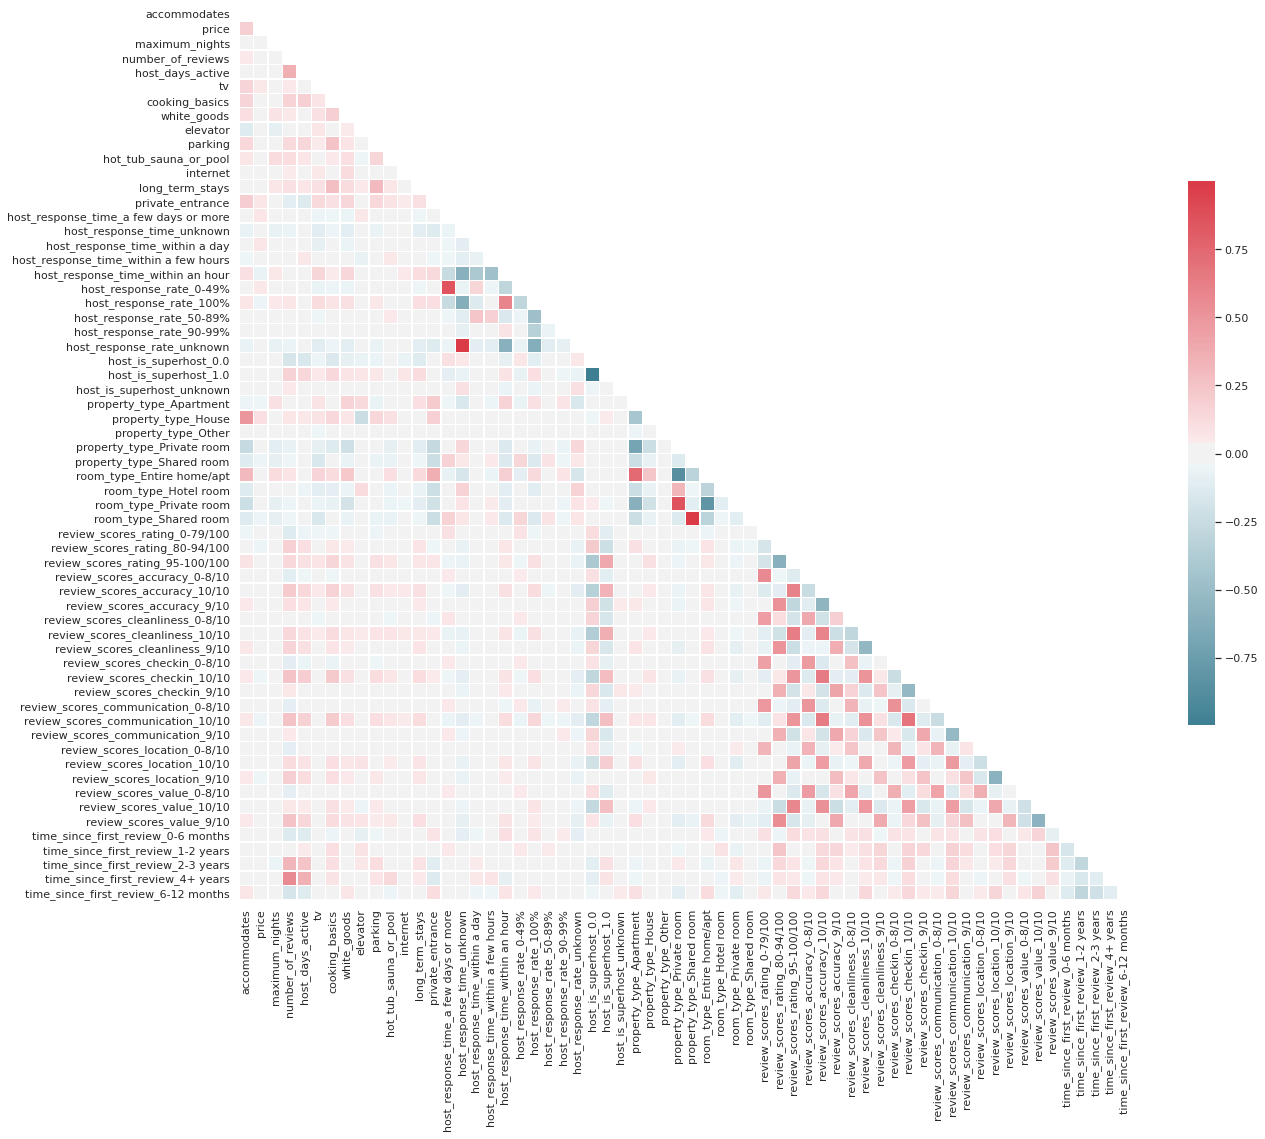

In [93]:
multi_collinearity_heatmap(df, figsize=(20, 20))

Now we will choose the variables who impact the analysis.

### Standardising and normalising

In [96]:
numerical_columns = ['accommodates', 'host_days_active', 
                     'maximum_nights',  
                     'number_of_reviews', 'price']

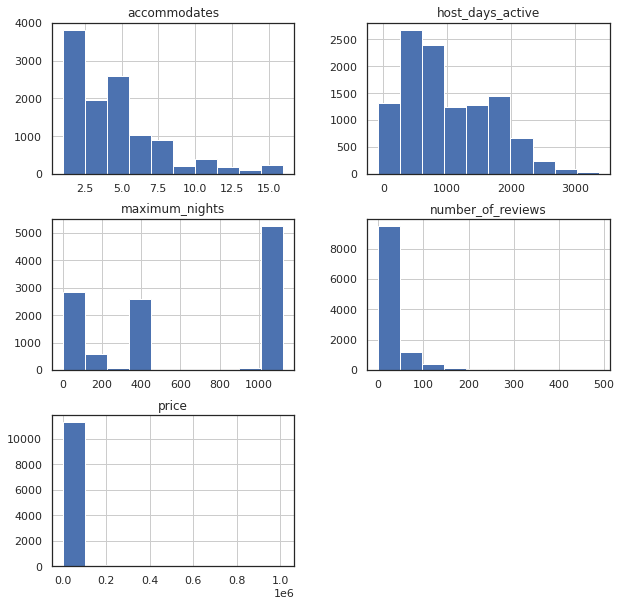

In [97]:
df[numerical_columns].hist(figsize=(10,10));

In [98]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns 
                     if i not in ['host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    df[col] = df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df[col] = np.log(df[col])

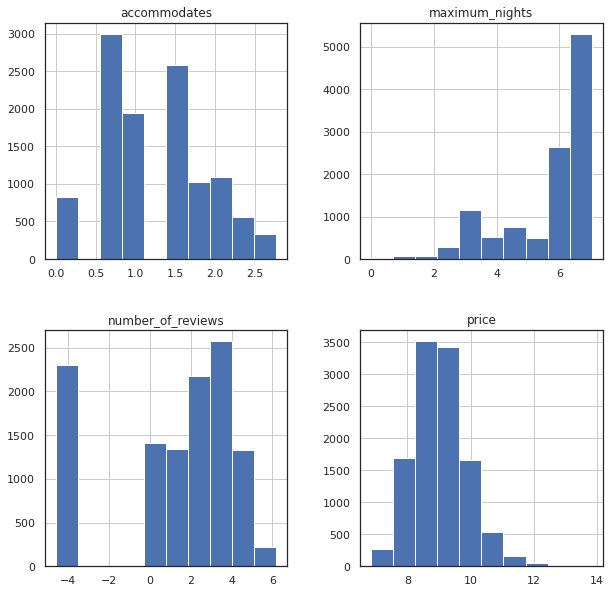

In [99]:
df[numerical_columns].hist(figsize=(10,10));

In [100]:
# Separating x and y
X = df.drop('price', axis=1)
y = df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Modeling

## Model 1: Spatial Hedonic Price Model (HPM)

The hedonic model involves regressing observed asking-prices for the listing against those attributes of a property hypothesized to be determinants of the asking-price. It comes from hedonic price theory which assumes that a commodity, such as a house can be viewed as an aggregation of individual components or attributes 

In [124]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

In [102]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [103]:
df.isnull().any()



accommodates                             False
price                                    False
maximum_nights                           False
number_of_reviews                        False
host_days_active                         False
tv                                       False
cooking_basics                           False
white_goods                              False
elevator                                 False
parking                                  False
hot_tub_sauna_or_pool                    False
internet                                 False
long_term_stays                          False
private_entrance                         False
host_response_time_a few days or more    False
host_response_time_unknown               False
host_response_time_within a day          False
host_response_time_within a few hours    False
host_response_time_within an hour        False
host_response_rate_0-49%                 False
host_response_rate_100%                  False
host_response

In [104]:
hpm_reg_start = time.time()

#Create instance of the model, `LinearRegression` function from 
#Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

#Now that the model has been fit we can make predictions by calling 
#the predict command. We are making predictions on the testing set:

training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.1 minutes

Training RMSE: 0.4502
Validation RMSE: 0.4841

Training r2: 0.398
Validation r2: 0.3647


This means that our features explain approximately 40% of the variance in our target variable.

In [105]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,9.546813,9.129593
1,8.833025,8.522691
2,9.680344,9.629610
3,8.488176,9.302433
4,8.140024,8.938489
...,...,...
2266,9.392662,9.771551
2267,7.824046,8.293279
2268,8.579041,9.794901
2269,7.341484,7.933789


And we can view this relationship graphically with a scatter plot:

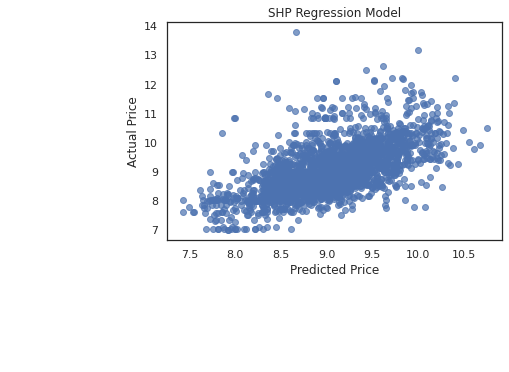

R^2 is: 0.3647


In [133]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()
print('R^2 is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4))))

Improving our model

We can try using Ridge Regularization to decrease the influence of less important features. Ridge Regularization is a process which shrinks the regression coefficients of less important features.

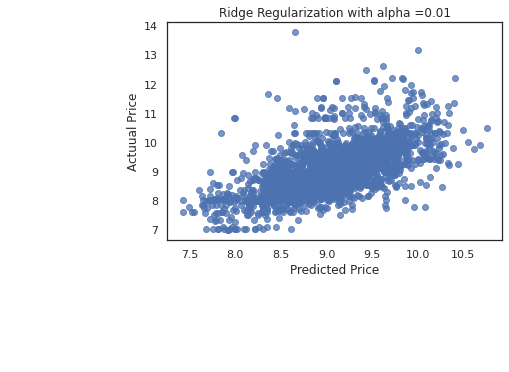

R^2 is: 0.3647


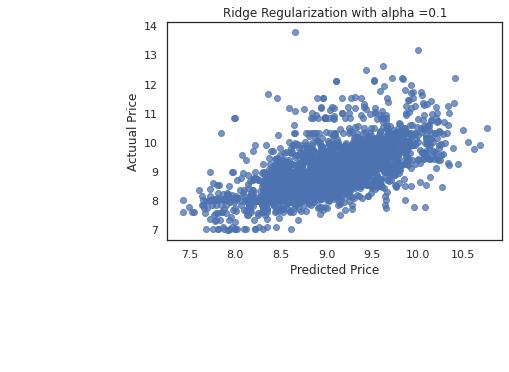

R^2 is: 0.3647


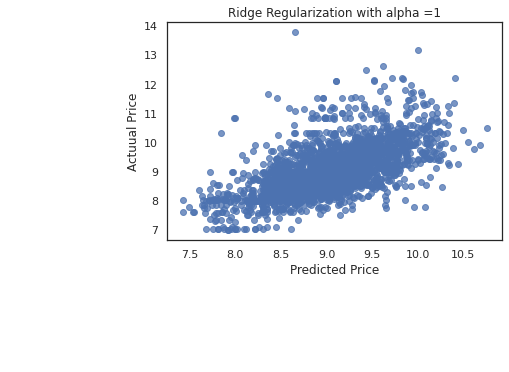

R^2 is: 0.3647


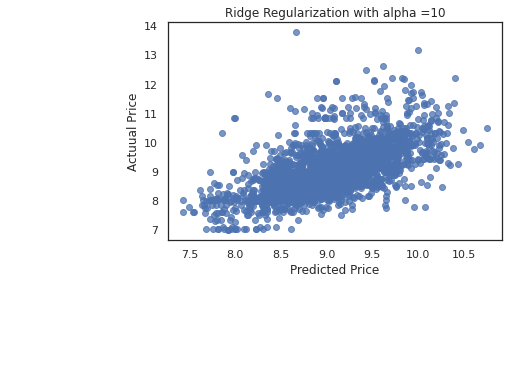

R^2 is: 0.3647


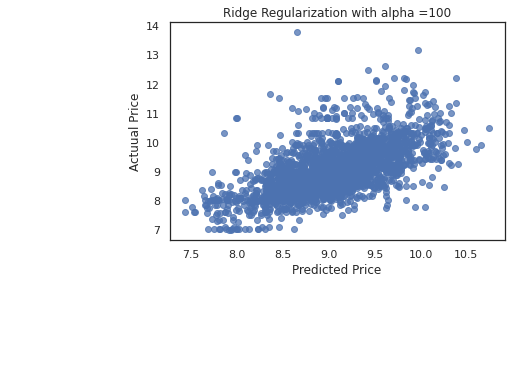

R^2 is: 0.365


In [135]:
lr = linear_model.LinearRegression()

for i in range(-2,3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    
    plt.scatter(preds_ridge, actual_values, alpha = .75, color = 'b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actuual Price')
    plt.title('Ridge Regularization with alpha ={}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
               round(ridge_model.score(X_test, y_test), 4),
               round(mean_squared_error(y_train, training_preds_hpm_reg), 4))
    plt.annotate(s = overlay, xy = (5.5, 2.5), size = 'x-large')
    plt.show()
    print('R^2 is: {}'.format(
                    round(ridge_model.score(X_test, y_test), 4)))

These models perform identically to the first model. In our case, adjusting the alpha did not substantially improve our model.

## Model 2: Gradient boosted decision trees

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

XGBoost (eXtreme Gradient Boosting) is an implementation of gradient boosted decision trees designed for speed and performance. Is a very popular algorithm that has recently been dominating applied machine learning for structured or tabular data.

This approach supports both regression and classification predictive modeling problems. 

In [139]:
!{sys.executable} -m pip install xgboost

     |████████████████████████████████| 157.5MB 51kB/s  eta 0:00:01     |██▎                             | 11.3MB 22.1MB/s eta 0:00:07     |██▌                             | 12.1MB 22.1MB/s eta 0:00:07     |████▋                           | 22.7MB 5.7MB/s eta 0:00:24     |███████                         | 34.8MB 3.0MB/s eta 0:00:41     |████████▊                       | 42.8MB 7.7MB/s eta 0:00:15     |█████████▍                      | 46.4MB 7.7MB/s eta 0:00:15     |█████████▊                      | 47.6MB 7.7MB/s eta 0:00:15     |███████████                     | 54.2MB 5.0MB/s eta 0:00:21     |█████████████▏                  | 64.8MB 4.9MB/s eta 0:00:19     |█████████████▍                  | 65.6MB 4.9MB/s eta 0:00:19     |██████████████▉                 | 73.2MB 5.8MB/s eta 0:00:15/s eta 0:00:14     |███████████████████▌            | 95.7MB 5.0MB/s eta 0:00:13     | 101.0MB 5.0MB/s eta 0:00:12     |█████████████████████           | 103.4MB 4.9MB/s eta 0:00:12     |██████████████████

In [140]:
import xgboost as xgb
from xgboost import plot_importance

In [142]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60, 1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg), 4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg), 4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg), 4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg), 4))

Time taken to run: 17.7 minutes

Training MSE: 0.1156
Validation MSE: 0.3121

Training r2: 0.8454
Validation r2: 0.5904


This means that our features explain approximately 84% of the variance in our target variable.

Feature importance

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

In [143]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
accommodates,0.091564
host_response_time_within an hour,0.045460
property_type_Shared room,0.043598
host_response_time_a few days or more,0.032708
host_is_superhost_1.0,0.029005
host_response_rate_90-99%,0.027859
host_response_time_unknown,0.027081
room_type_Private room,0.026077
private_entrance,0.025962
host_response_time_within a day,0.023747


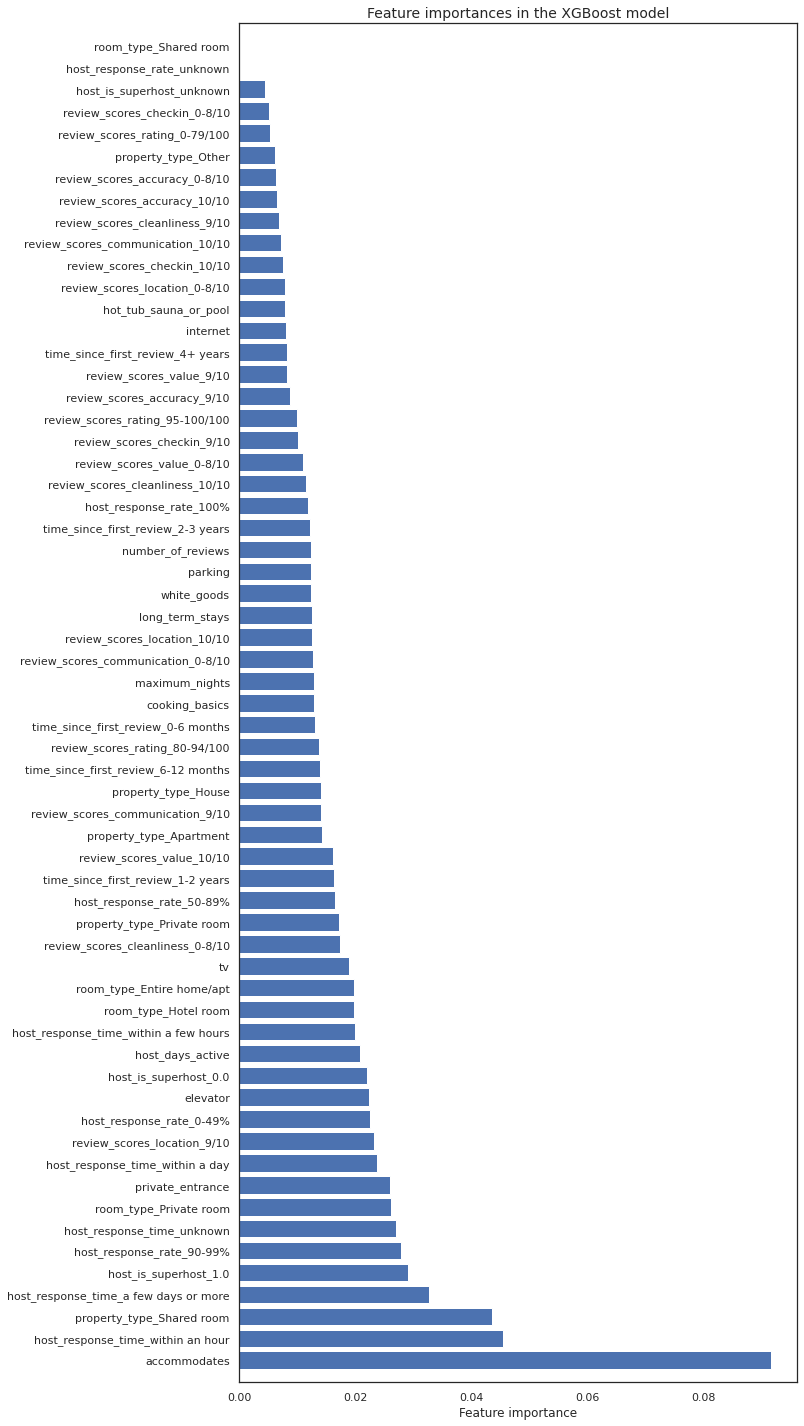

In [144]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()